# Human-intepretable Machine Learning

Interpreting Machine Learning models is no longer a luxury but a necessity. To understand and need and importance of human-interpretable machine learning, feel free to check out the article, [_Explainable Artificial Intelligence (Part 1) — The Importance of Human Interpretable Machine Learning_](https://towardsdatascience.com/human-interpretable-machine-learning-part-1-the-need-and-importance-of-model-interpretation-2ed758f5f476).

In this tutorial we will take a look at various ways to explain potential black-box machine learning models in a model-agnostic way. We will be working on a real-world dataset on Census income, also known as the Adult dataset available in the UCI ML Repository where we will be predicting if the potential income of people is more than $50K/yr or not.

The purpose of this tutorial is manifold. The first main objective is to familiarize ourselves with the major state-of-the-art model interpretation frameworks out there (a lot of them being extensions of LIME - the original framework and approach proposed for model interpretation).

[__LIME__](https://github.com/marcotcr/lime) (short for local interpretable model-agnostic explanations) is based on the work presented in the paper, ["Why Should I Trust You?": Explaining the Predictions of Any Classifier"](https://arxiv.org/pdf/1602.04938.pdf) which talks about a novel explanation technique that explains the predictions of any classifier in an interpretable and faithful manner, by learning an interpretable model locally around the prediction. It also covers a method to explain models by presenting representative individual predictions and their explanations in a non-redundant way.

We cover usage of the following model interpretation frameworks in our tutorial.
- [__ELI5__](https://github.com/TeamHG-Memex/eli5)
- [__Skater__](https://github.com/datascienceinc/Skater)
- [__SHAP__](https://github.com/slundberg/shap)

The major model interpretation techniques we will be covering in this tutorial include the following.

- Interpretable Model Methods
- Feature Importances
- Partial Dependence Plots
- Individual Conditional Expectation Plots
- Model Prediction Explanations with Local Interpretation
- Building Interpretable Models with Surrogate Tree-based Models
- Model Prediction Explanation with SHAP values
- Dependence & Interaction Plots with SHAP

_Tutorial by [Dipanjan (DJ) Sarkar](https://www.linkedin.com/in/dipanzan/)_

# Load Dependencies

In [1]:
import pandas as pd
import numpy as np
import model_evaluation_utils as meu
import matplotlib.pyplot as plt
from collections import Counter
import shap
import eli5
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

# Load the Census Income Dataset

In [2]:
data, labels = shap.datasets.adult(display=True)
labels = np.array([int(label) for label in labels])

print(data.shape, labels.shape)
data.head()

(32561, 12) (32561,)


Age          Workclass  Education-Num       Marital Status  \
0  39.0          State-gov           13.0        Never-married   
1  50.0   Self-emp-not-inc           13.0   Married-civ-spouse   
2  38.0            Private            9.0             Divorced   
3  53.0            Private            7.0   Married-civ-spouse   
4  28.0            Private           13.0   Married-civ-spouse   

           Occupation    Relationship    Race      Sex  Capital Gain  \
0        Adm-clerical   Not-in-family   White     Male        2174.0   
1     Exec-managerial         Husband   White     Male           0.0   
2   Handlers-cleaners   Not-in-family   White     Male           0.0   
3   Handlers-cleaners         Husband   Black     Male           0.0   
4      Prof-specialty            Wife   Black   Female           0.0   

   Capital Loss  Hours per week         Country  
0           0.0            40.0   United-States  
1           0.0            13.0   United-States  
2           0.0            40.0   United-States  
3           0.0            40.0   United-States  
4           0.0            40.0            Cuba

# Understanding the Census Income Dataset

Let's now take a look at our dataset attributes and understand their meaning and significance.


| Attribute Name | Type | Description |
|-----------------------|----------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Age | Continuous | Represents age of the person |
| Workclass | Categorical | Represents the nature of working class\category<br>(Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,  <br>Local-gov, State-gov, Without-pay, Never-worked) |
| Education-Num | Categorical | Numeric representation of educational qualification.<br>Ranges from 1-16.<br>(Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, <br>9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool) |
| Marital Status | Categorical | Represents the marital status of the person<br>(Married-civ-spouse, Divorced, Never-married, Separated, <br>Widowed, Married-spouse-absent, Married-AF-spouse) |
| Occupation | Categorical | Represents the type of profession\job of the person<br>(Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, <br>Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, <br>Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, <br>Armed-Forces) |
| Relationship | Categorical | Represents the relationship status of the person<br>(Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried) |
| Race | Categorical | Represents the race of the person<br>(White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black) |
| Sex | Categorical | Represents the gender of the person<br>(Female, Male) |
| Capital Gain | Continuous | The total capital gain for the person |
| Capital Loss | Continuous | The total capital loss for the person |
| Hours per week | Continuous | Total hours spent working per week |
| Country | Categorical | The country where the person is residing |
| Income Label (labels) | Categorical  (class label) | The class label column is the one we want to predict<br>(False: Income <= \$50K & True: Income > \$50K) |                                                                                                                                                                |

We have a total of 12 features and our objective is to predict if the income of a person will be more than \$50K (True) or less than \$50K (False). Hence we will be building and interpreting a classification model

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
Age               32561 non-null float32
Workclass         32561 non-null category
Education-Num     32561 non-null float32
Marital Status    32561 non-null category
Occupation        32561 non-null category
Relationship      32561 non-null category
Race              32561 non-null category
Sex               32561 non-null category
Capital Gain      32561 non-null float32
Capital Loss      32561 non-null float32
Hours per week    32561 non-null float32
Country           32561 non-null category
dtypes: category(7), float32(5)
memory usage: 862.2 KB


# Basic Feature Engineering

In [4]:
data = pd.get_dummies(data)
data.head()

Age  Education-Num  Capital Gain  Capital Loss  Hours per week  \
0  39.0           13.0        2174.0           0.0            40.0   
1  50.0           13.0           0.0           0.0            13.0   
2  38.0            9.0           0.0           0.0            40.0   
3  53.0            7.0           0.0           0.0            40.0   
4  28.0           13.0           0.0           0.0            40.0   

   Workclass_ ?  Workclass_ Federal-gov  Workclass_ Local-gov  \
0             0                       0                     0   
1             0                       0                     0   
2             0                       0                     0   
3             0                       0                     0   
4             0                       0                     0   

   Workclass_ Never-worked  Workclass_ Private  ...  Country_ Portugal  \
0                        0                   0  ...                  0   
1                        0                   0  ...                  0   
2                        0                   1  ...                  0   
3                        0                   1  ...                  0   
4                        0                   1  ...                  0   

   Country_ Puerto-Rico  Country_ Scotland  Country_ South  Country_ Taiwan  \
0                     0                  0               0                0   
1                     0                  0               0                0   
2                     0                  0               0                0   
3                     0                  0               0                0   
4                     0                  0               0                0   

   Country_ Thailand  Country_ Trinadad&Tobago  Country_ United-States  \
0                  0                         0                       1   
1                  0                         0                       1   
2                  0                         0                       1   
3                  0                         0                       1   
4                  0                         0                       0   

   Country_ Vietnam  Country_ Yugoslavia  
0                 0                    0  
1                 0                    0  
2                 0                    0  
3                 0                    0  
4                 0                    0  

[5 rows x 91 columns]

In [5]:
Counter(labels)

Counter({0: 24720, 1: 7841})

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((22792, 91), (9769, 91))

In [7]:
X_train.head(3)

Age  Education-Num  Capital Gain  Capital Loss  Hours per week  \
19749  34.0            9.0           0.0        2179.0            12.0   
1216   48.0           10.0        7688.0           0.0            40.0   
27962  23.0           10.0           0.0           0.0            30.0   

       Workclass_ ?  Workclass_ Federal-gov  Workclass_ Local-gov  \
19749             0                       0                     0   
1216              0                       0                     0   
27962             0                       0                     0   

       Workclass_ Never-worked  Workclass_ Private  ...  Country_ Portugal  \
19749                        0                   0  ...                  0   
1216                         0                   0  ...                  0   
27962                        0                   0  ...                  0   

       Country_ Puerto-Rico  Country_ Scotland  Country_ South  \
19749                     0                  0               0   
1216                      0                  0               0   
27962                     0                  0               0   

       Country_ Taiwan  Country_ Thailand  Country_ Trinadad&Tobago  \
19749                0                  0                         0   
1216                 0                  0                         0   
27962                0                  0                         0   

       Country_ United-States  Country_ Vietnam  Country_ Yugoslavia  
19749                       1                 0                    0  
1216                        1                 0                    0  
27962                       1                 0                    0  

[3 rows x 91 columns]

# Building a Boosting Classification Model

In [8]:
%%time

import xgboost as xgb

xgc = xgb.XGBClassifier(n_estimators=500, max_depth=10, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

CPU times: user 51.9 s, sys: 156 ms, total: 52.1 s
Wall time: 52.5 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [9]:
predictions = xgc.predict(X_test)
predictions[:10]

array([0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [10]:
class_labels = list(set(labels))
meu.display_model_performance_metrics(true_labels=y_test, 
                                      predicted_labels=predictions, 
                                      classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8644
Precision: 0.8599
Recall: 0.8644
F1 Score: 0.8612

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      7455
           1       0.74      0.65      0.69      2314

    accuracy                           0.86      9769
   macro avg       0.82      0.79      0.80      9769
weighted avg       0.86      0.86      0.86      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       6936   519
        1        806  1508


# Using Interpretable Models - Feature Importance Plots

In [11]:
booster = xgc.get_booster()
fs_dict = booster.get_score(importance_type='gain')
fn = booster.feature_names
fs = np.array([fs_dict.get(f, 0.) 
                    for f in fn], dtype=np.float32)
feature_imps = {k: v for k, v in zip(fn, fs)}
feature_imps_list = sorted(list(feature_imps.items()), key=lambda x:-x[1])
feature_names = [r[0] for r in feature_imps_list]
feature_scores = [r[1] for r in feature_imps_list]

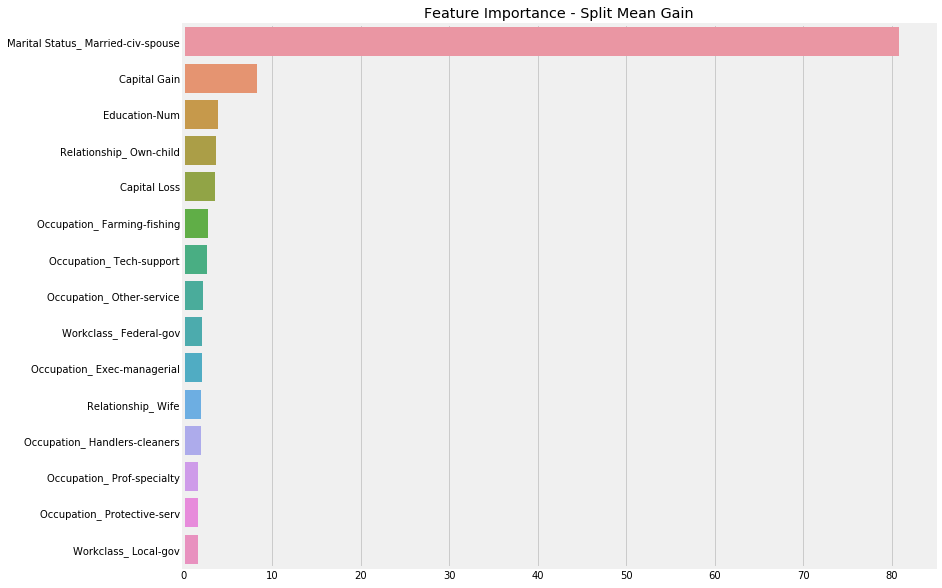

In [12]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot(1, 1, 1)
sns.barplot(y=feature_names[:15], 
            x = feature_scores[:15],
            orient='h', ax=ax)
t = ax.set_title("Feature Importance - Split Mean Gain")

# Interpretable Model based Interpretation with ELI5

[__ELI5__](https://github.com/TeamHG-Memex/eli5) is a Python package which helps to debug machine learning classifiers and explain their predictions in an easy to understand an intuitive way. It is perhaps the easiest of the three machine learning frameworks to get started with since it involves minimal reading of documentation! However it doesn't support true model-agnostic interpretations and support for models are mostly limited to tree-based and other parametric\linear models. Let's look at some intuitive ways of model interpretation with ELI5 on our classification model. 

### Installation Instructions

We recommend installing this framework using __`pip install eli5`__ since the `conda` version appears to be a bit out-dated. Also feel free to check out [__the documentation__](https://eli5.readthedocs.io/en/latest/overview.html) as needed.

## Global Interpretation - Feature Importances with ELI5

Typically for tree-based models ELI5 does nothing special but uses the out-of-the-box feature importance computation methods which we discussed in the previous section. By default, __'gain'__ is used, that is the average gain of the feature when it is used in trees.

In [13]:
eli5.show_weights(xgc.get_booster())

## Local Interpretation - Explaining Model Prediction Decisions with ELI5

One of the best way to explain model prediction decisions to either a technical or a more business-oriented individual, is to  examine individual data-point predictions. Typically, ELI5 does this by showing weights for each feature depicting how influential it might have been in contributing to the final prediction decision across all trees. The idea for weight calculation is described in http://blog.datadive.net/interpreting-random-forests/; ELI5 provides an independent implementation of this algorithm for XGBoost and most scikit-learn tree ensembles which is definitely on the path towards model-agnostic interpretation but not purely model-agnostic like LIME.

Typically, the prediction can be defined as the sum of the feature contributions + the “bias”

### Predicting when a person's income <= \$50K 

Here we can see the most influential features being the __`Age`, `Hours per week`, `Marital Status`, `Occupation` & `Relationship`__

In [14]:
doc_num = 0
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(data.columns),
                     show_feature_values=True, top=(7, 8))

Actual Label: 0
Predicted Label: 0


### Predicting when a person's income > \$50K 

Here we can see the most influential features being the __`Education`, `Relationship`, `Occupation`, `Hours per week` & `Marital Status`__

In [15]:
doc_num = 2
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(data.columns),
                     show_feature_values=True, top=(8, 7))

Actual Label: 1
Predicted Label: 1


It is definitely interesting to see how similar features play an influential role in explaining model prediction decisions for both classes!

# Interpretable Model Interpretation with RuleFit Models

The RuleFit algorithm by Friedman and Popescu learns sparse linear models that include automatically detected interaction effects in the form of decision rules.

The linear regression model does not account for interactions between features. RuleFit fills this gap by learning a sparse linear model with the original features and also a number of new features that are decision rules. These new features capture interactions between the original features. RuleFit automatically generates these features from decision trees. Each path through a tree can be transformed into a decision rule by combining the split decisions into a rule. The node predictions are discarded and only the splits are used in the decision rule.

- Rules are extracted from tree ensemble, which allow us to take advantage of existing fast algorithms (such as bagged decision trees, or gradient boosting) to produce such tree ensembles. 
- Too similar or duplicated rules are then removed, based on a similarity threshold of their supports.. The main goal of the SkopeRules package is to provide rules verifying precision and recall conditions. 

In [235]:
from skrules import SkopeRules
import re

In [236]:
col_names = [re.sub(r"[\s|&|(|)]", '_', item) for item in data.columns]
col_names = [re.sub(r"[-]", '_', item) for item in col_names]
col_names = [''.join(t.strip() 
                     for t in re.sub(r"\?", 'Unknown', item).split()) for item in col_names]

X_train_copy = X_train.copy(deep=True)
X_train_copy.columns = col_names
X_test_copy = X_test.copy(deep=True)
X_test_copy.columns = col_names

In [267]:
%%time
skope_rules_clf = SkopeRules(feature_names=list(X_train_copy.columns), random_state=42, 
                             n_estimators=250, max_depth=10, max_depth_duplication=8,
                             recall_min=0.03, precision_min=0.03, max_samples=0.85, bootstrap=True,
                             verbose=1, n_jobs=4)
skope_rules_clf.fit(X_train_copy, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   12.2s remaining:   12.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   13.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   11.8s remaining:   11.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   12.3s finished


CPU times: user 15min 20s, sys: 8.28 s, total: 15min 29s
Wall time: 15min 19s


SkopeRules(bootstrap=True, bootstrap_features=False,
           feature_names=['Age', 'Education_Num', 'Capital_Gain',
                          'Capital_Loss', 'Hours_per_week',
                          'Workclass__Unknown', 'Workclass__Federal_gov',
                          'Workclass__Local_gov', 'Workclass__Never_worked',
                          'Workclass__Private', 'Workclass__Self_emp_inc',
                          'Workclass__Self_emp_not_inc', 'Workclass__State_gov',
                          'Workclass__Without_...
                          'Occupation__Exec_managerial',
                          'Occupation__Farming_fishing',
                          'Occupation__Handlers_cleaners',
                          'Occupation__Machine_op_inspct',
                          'Occupation__Other_service', ...],
           max_depth=10, max_depth_duplication=8, max_features=1.0,
           max_samples=0.85, max_samples_features=1.0, min_samples_split=2,
           n_estimators=250

In [268]:
predictions = skope_rules_clf.predict(X_test_copy)
predictions[:10]

array([0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [269]:
meu.display_model_performance_metrics(true_labels=y_test, 
                                      predicted_labels=predictions, 
                                      classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.7797
Precision: 0.8449
Recall: 0.7797
F1 Score: 0.7944

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.95      0.75      0.84      7455
           1       0.52      0.86      0.65      2314

    accuracy                           0.78      9769
   macro avg       0.73      0.81      0.74      9769
weighted avg       0.84      0.78      0.79      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       5628  1827
        1        325  1989


In [273]:
for item in skope_rules_clf.rules_[:5]:
    print(item)
    print()

('Age > 26.5 and Capital_Gain <= 727.5 and Capital_Loss <= 1566.5 and Education_Num > 12.5 and Marital_Status__Married_civ_spouse > 0.5 and Occupation__Farming_fishing <= 0.5 and Occupation__Machine_op_inspct <= 0.5 and Occupation__Other_service <= 0.5', (0.6889122438255386, 0.2757097791798107, 2))

('Age > 25.5 and Capital_Gain <= 3120.0 and Capital_Loss <= 629.0 and Education_Num > 11.5 and Hours_per_week > 34.5 and Marital_Status__Married_civ_spouse > 0.5 and Occupation__Craft_repair <= 0.5 and Occupation__Other_service <= 0.5', (0.6788942052099947, 0.27257203842049094, 2))

('Age <= 75.5 and Age > 26.5 and Capital_Gain <= 3120.0 and Capital_Loss <= 629.0 and Education_Num > 12.5 and Hours_per_week > 17.5 and Marital_Status__Married_civ_spouse > 0.5 and Occupation__Other_service <= 0.5', (0.6735246345425013, 0.2681034482758621, 2))

('Age > 25.5 and Capital_Gain <= 3120.0 and Capital_Loss <= 742.5 and Education_Num > 12.5 and Hours_per_week > 31.0 and Marital_Status__Married_civ_spo

# Model Agnostic Interpretation - Partial Dependence Plot

The partial dependence plot (short PDP or PD plot) shows the marginal effect one or two features have on the predicted outcome of a machine learning model. A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex. 

We perturb the feature of interest and predict with our trained model for various values of the feature of interest keeping other features as they are to see the effect the feature has on the model.

In [149]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        # perturb feature values for each %tile bin value
        # keep other features as they are
        frame.loc[:, xs] = j
        # evaluate model performance based on the perturbation
        par_dep_i = pd.DataFrame(model.predict_proba(frame)[:, 1])
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame


In [150]:
edu_pdp = par_dep('Education-Num', X_test, xgc)
edu_pdp

Education-Num  partial_dependence
0            1.00            0.093255
1            1.75            0.093255
2            2.50            0.108369
3            3.25            0.108369
4            4.00            0.131060
5            4.75            0.133792
6            5.50            0.133579
7            6.25            0.133579
8            7.00            0.132420
9            7.75            0.174620
10           8.50            0.191505
11           9.25            0.191505
12          10.00            0.228137
13          10.75            0.236316
14          11.50            0.241177
15          12.25            0.241338
16          13.00            0.294999
17          13.75            0.327083
18          14.50            0.373181
19          15.25            0.373181

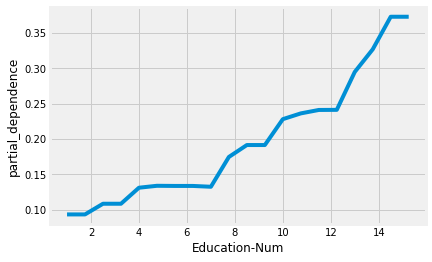

In [151]:
p = sns.lineplot(x='Education-Num', y='partial_dependence', data=edu_pdp)

# Model Agnostic Interpretation - ICE (Individual Conditional Expectation) Plot


Individual Conditional Expectation (ICE) plots display one line per instance that shows how the instance’s prediction changes when a feature changes.

The partial dependence plot for the average effect of a feature is a global method because it does not focus on specific instances, but on an overall average. The equivalent to a PDP for individual data instances is called individual conditional expectation (ICE) plot (Goldstein et al. 201729). 

An ICE plot visualizes the dependence of the prediction on a feature for each instance separately, resulting in one line per instance, compared to one line overall in partial dependence plots. A PDP is the average of the lines of an ICE plot. 

The values for a line (and one instance) can be computed by keeping all other features the same, creating variants of this instance by replacing the feature’s value with values from a grid and making predictions with the black box model for these newly created instances. The result is a set of points for an instance with the feature value from the grid and the respective predictions.

In [152]:
def get_percentile_dict(yhat, frame):

    """ Returns the percentiles of a column, yhat, as the indices based on 
        another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.reset_index(inplace=True, drop=True)
    sort_df.sort_values(yhat, inplace=True)
    
    # find top and bottom percentiles
    percentiles_dict = {}
    
    percentiles_dict[0] = sort_df.iloc[0].name
    # find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.iloc[i * inc].name
    percentiles_dict[99] = sort_df.iloc[sort_df.shape[0]-1].name

    return percentiles_dict



def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='YlOrRd',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='k--', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)

One place to start with ICE is to calculate ICE curves at every decile of predicted probabilities in a dataset, giving an indication of local prediction behavior across the dataset. 

In [154]:
X_test_cp = X_test.reset_index(drop=True).copy(deep=True)

yhat_test = pd.concat([X_test_cp, pd.DataFrame(xgc.predict_proba(X_test_cp)[:,1])], axis=1)
yhat_test = yhat_test.rename(columns={0:'p_gt_50K'})
edu_percentiles = get_percentile_dict('p_gt_50K', yhat_test)
edu_percentiles

{0: 4330,
 10: 1173,
 20: 4726,
 30: 5139,
 40: 9759,
 50: 8681,
 60: 1000,
 70: 4380,
 80: 3171,
 90: 410,
 99: 8502}

In [155]:
edu_bins = edu_pdp['Education-Num'].tolist()
edu_bins

[1.0,
 1.75,
 2.5,
 3.25,
 4.0,
 4.75,
 5.5,
 6.25,
 7.0,
 7.75,
 8.5,
 9.25,
 10.0,
 10.75,
 11.5,
 12.25,
 13.0,
 13.75,
 14.5,
 15.25]

In [158]:
for row in sorted(edu_percentiles.keys()):
    col_name = 'Percentile_' + str(row)
    
    # ICE curves for PAY_0 across percentiles at bins_PAY_0 intervals
    edu_pdp[col_name] = par_dep('Education-Num', 
                                X_test_cp.iloc[[edu_percentiles[row]]],
                                xgc,
                                bins=edu_bins)['partial_dependence']

In [159]:
edu_pdp

Education-Num  partial_dependence  Percentile_0  Percentile_10  \
0            1.00            0.093255  6.689493e-07       0.000101   
1            1.75            0.093255  6.689493e-07       0.000101   
2            2.50            0.108369  7.093734e-07       0.000126   
3            3.25            0.108369  7.093734e-07       0.000126   
4            4.00            0.131060  2.084647e-06       0.000559   
5            4.75            0.133792  1.237942e-06       0.000515   
6            5.50            0.133579  5.391793e-07       0.000144   
7            6.25            0.133579  5.391793e-07       0.000144   
8            7.00            0.132420  5.401474e-07       0.000267   
9            7.75            0.174620  4.797523e-07       0.000233   
10           8.50            0.191505  4.623242e-07       0.000221   
11           9.25            0.191505  4.623242e-07       0.000221   
12          10.00            0.228137  1.705671e-06       0.000339   
13          10.75            0.236316  2.715069e-06       0.000547   
14          11.50            0.241177  1.963973e-06       0.000274   
15          12.25            0.241338  1.963973e-06       0.000274   
16          13.00            0.294999  2.321565e-06       0.000187   
17          13.75            0.327083  1.244387e-05       0.000309   
18          14.50            0.373181  1.333561e-05       0.000310   
19          15.25            0.373181  1.333561e-05       0.000310   

    Percentile_20  Percentile_30  Percentile_40  Percentile_50  Percentile_60  \
0        0.002557       0.000665       0.001551       0.004571       0.006028   
1        0.002557       0.000665       0.001551       0.004571       0.006028   
2        0.004906       0.001111       0.002178       0.009308       0.008840   
3        0.004906       0.001111       0.002178       0.009308       0.008840   
4        0.010378       0.003616       0.006565       0.021068       0.021652   
5        0.003807       0.006403       0.009568       0.033742       0.019357   
6        0.000976       0.002420       0.038088       0.013766       0.047079   
7        0.000976       0.002420       0.038088       0.013766       0.047079   
8        0.001490       0.005240       0.027482       0.027651       0.039977   
9        0.001033       0.005071       0.015096       0.031540       0.145501   
10       0.001180       0.004508       0.014804       0.033171       0.131961   
11       0.001180       0.004508       0.014804       0.033171       0.131961   
12       0.001079       0.006200       0.055092       0.046112       0.230758   
13       0.001074       0.007815       0.063889       0.034167       0.178982   
14       0.001702       0.008271       0.085783       0.040684       0.213248   
15       0.001702       0.008271       0.085783       0.040684       0.213248   
16       0.001943       0.007371       0.201787       0.152622       0.409611   
17       0.003564       0.011743       0.326665       0.417320       0.459780   
18       0.002424       0.009586       0.227347       0.651972       0.763215   
19       0.002424       0.009586       0.227347       0.651972       0.763215   

    Percentile_70  Percentile_80  Percentile_90  Percentile_99  
0        0.040248       0.151551       0.145415       0.999946  
1        0.040248       0.151551       0.145415       0.999946  
2        0.049686       0.202150       0.272724       0.999975  
3        0.049686       0.202150       0.272724       0.999975  
4        0.155822       0.462429       0.164994       0.999961  
5        0.171128       0.479025       0.188578       0.999943  
6        0.262373       0.260177       0.318735       0.999959  
7        0.262373       0.260177       0.318735       0.999959  
8        0.115685       0.245813       0.368874       0.999956  
9        0.229074       0.377975       0.556765       0.999958  
10       0.292101       0.462092       0.546005       0.999960  
11       0.292101       0.462092       0.546005    

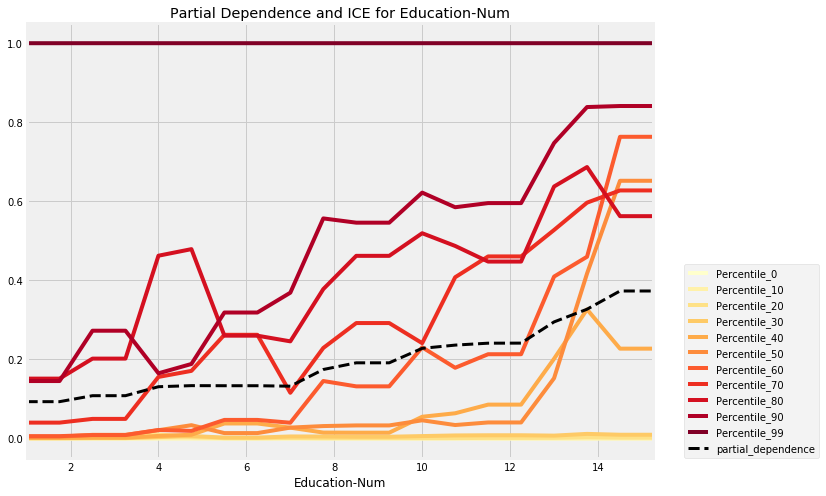

In [160]:
plot_par_dep_ICE('Education-Num', edu_pdp)

Monotonic increasing prediction behavior for `Education-Num` is displayed for all percentiles of model predictions. Predition behavior is different at different deciles, but not abnormal or vastly different from the average prediction behavior represented by the black dotted partial dependence curve. 

If a variable's partial dependence curve is mostly flat, the model should not be very sensitive to changes in the value of the variable and this variable would be expected to have low importance. If your model is placing high importance on a variable with a flat partial dependence curve, this could indicate a problem with your model training process, or the partial dependence itself could be misleading because the variable in question could be part of a group of strongly correlated variables or variables with strong interactions. ICE will be used to help increase the trustworthiness of partial dependence in the steps below. If the average global behavior of partial dependence is representative of the individual ICE curves, the partial dependence is likely trustworthy. If ICE curves diverge from partial dependence curves, this is an indication of strong correlation or interactions in the model training data which can cause accuracy problems in many cases. ICE also clues users into any local disparate impact, drift, or security problems: ICE can show if certain regions of the model's response function are overly sensitive to an indivual's demographic segment or to any other changes in input variable values that may be interesting from a model drift or adversarial attack perspective.

# Model Agnostic Interpretation with Skater

In [16]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(training_data=X_train, training_labels=y_train, feature_names=list(data.columns))
im_model = InMemoryModel(xgc.predict_proba, examples=X_train, model_type='classifier', unique_values=[0, 1],
                           feature_names=list(data.columns), target_names=['$50K or less', 'More than $50K'])

# Global Interpretations

## Feature Importances

2019-07-31 07:56:51,342 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2019-07-31 07:56:53,396 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[91/91] features ████████████████████ Time elapsed: 623 seconds

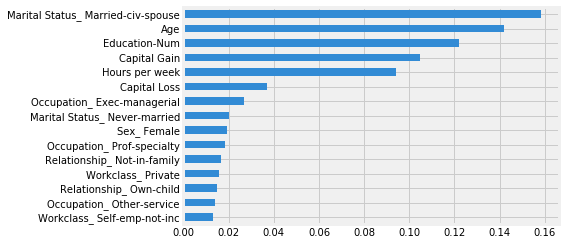

In [17]:
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=True, 
                                                               n_jobs=1, n_features=15, n_samples=23000)

## Partial Dependence Plots

2019-07-31 08:25:38,804 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[6/6] grid cells ████████████████████ Time elapsed: 4 seconds

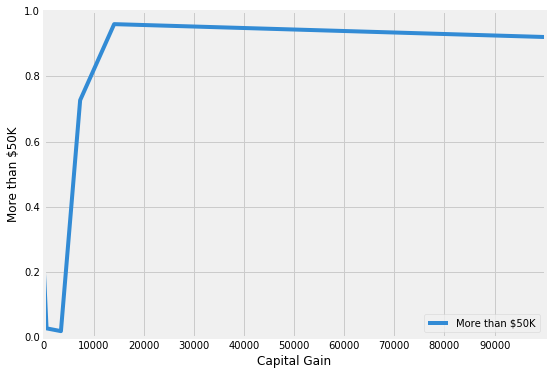

In [36]:
r = interpreter.partial_dependence.plot_partial_dependence(['Capital Gain'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=10000, 
                                                           with_variance=True, figsize = (8, 6))
yl = r[0][1].set_ylim(0, 1) 
r[0][1].ticklabel_format(useOffset=False, style='plain')
s, e = r[0][1].get_xlim()
xl = r[0][1].set_xticks(np.arange(s, e, 10000))

2019-07-31 08:26:24,349 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[44/44] grid cells ████████████████████ Time elapsed: 37 seconds

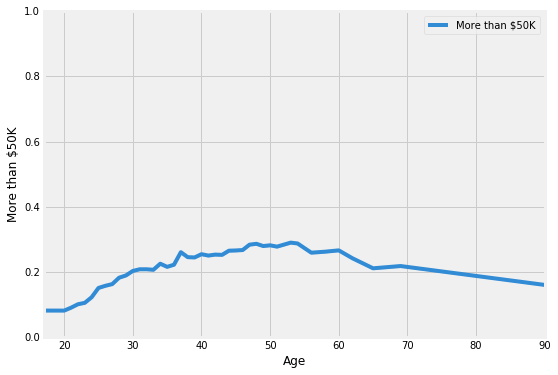

In [37]:
r = interpreter.partial_dependence.plot_partial_dependence(['Age'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=10000, 
                                                           with_variance=True, figsize = (8, 6))
yl = r[0][1].set_ylim(0, 1) 
r[0][1].ticklabel_format(useOffset=False, style='plain')
s, e = r[0][1].get_xlim()

2019-07-31 08:27:19,320 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[16/16] grid cells ████████████████████ Time elapsed: 14 seconds

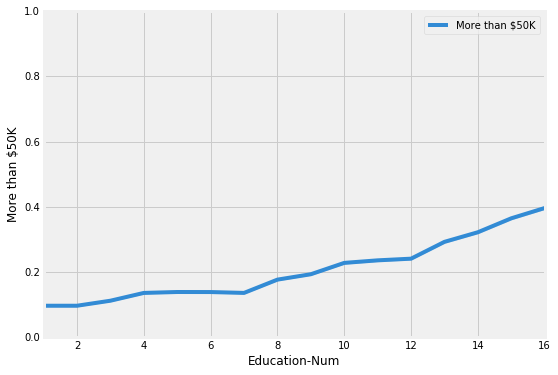

In [38]:
r = interpreter.partial_dependence.plot_partial_dependence(['Education-Num'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=10000, 
                                                           with_variance=True, figsize = (8, 6))
yl = r[0][1].set_ylim(0, 1) 
r[0][1].ticklabel_format(useOffset=False, style='plain')
s, e = r[0][1].get_xlim()

2019-07-31 08:31:04,015 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[2/2] grid cells ████████████████████ Time elapsed: 2 seconds

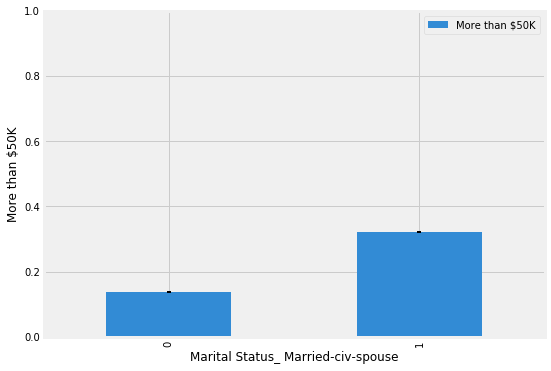

In [42]:
r = interpreter.partial_dependence.plot_partial_dependence(['Marital Status_ Married-civ-spouse'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=10000, 
                                                           with_variance=True, figsize = (8, 6))
yl = r[0][1].set_ylim(0, 1) 
r[0][1].get_yaxis().get_major_formatter().set_scientific(False)
s, e = r[0][1].get_xlim()

2019-07-31 08:32:04,003 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[1168/1168] grid cells ████████████████████ Time elapsed: 1602 seconds

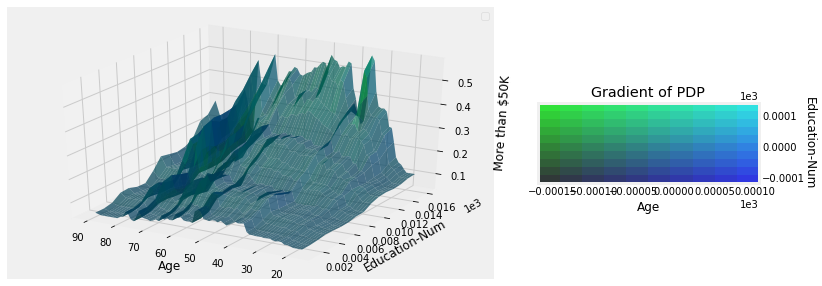

In [43]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('Age', 'Education-Num')], 
                                                                    im_model, grid_range=(0,1), 
                                                                    n_samples=10000,
                                                                    figsize=(12, 5),
                                                                    grid_resolution=100)

2019-07-31 08:59:04,167 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[32/32] grid cells ████████████████████ Time elapsed: 41 seconds

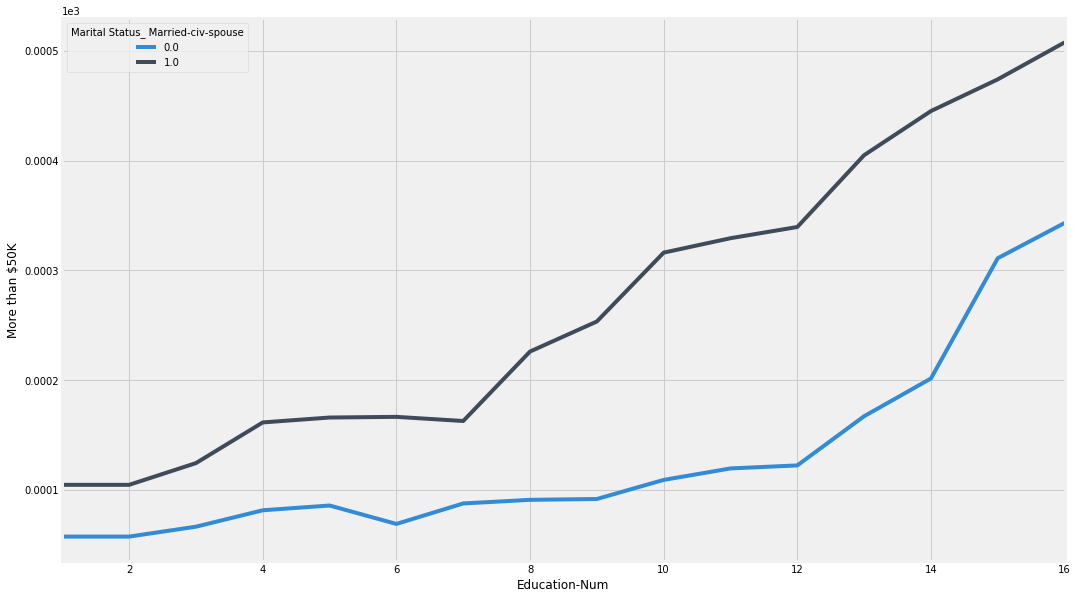

In [44]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('Education-Num', 'Marital Status_ Married-civ-spouse')], 
                                                                    im_model, grid_range=(0,1), 
                                                                    n_samples=10000,
                                                                    figsize=(12, 5),
                                                                    grid_resolution=100)

2019-07-31 09:00:04,137 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[160/160] grid cells ████████████████████ Time elapsed: 231 seconds

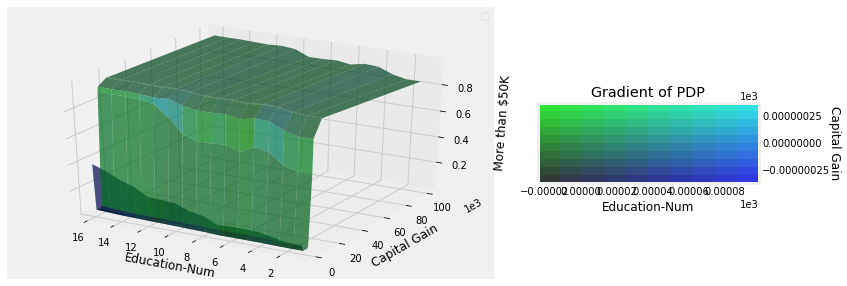

In [45]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('Education-Num', 'Capital Gain')], 
                                                                    im_model, grid_range=(0,1), 
                                                                    n_samples=10000,
                                                                    figsize=(12, 5),
                                                                    grid_resolution=100)

# Local Interpretations with Skater

Local Interpretation could be possibly be achieved in two ways. Firstly, one could possibly approximate the behavior of a complex predictive model in the vicinity of a single input using a simple interpretable auxiliary or surrogate model (e.g. Linear Regressor). Secondly, one could use the base estimator to understand the behavior of a single prediction using intuitive approximate functions based on inputs and outputs.

## Local Interpretable Model-Agnostic Explanations(LIME)
LIME is a novel algorithm designed by Riberio Marco, Singh Sameer, Guestrin Carlos to access the behavior of the any base estimator(model) using interpretable surrogate models (e.g. linear classifier/regressor). Such form of comprehensive evaluation helps in generating explanations which are locally faithful but may not align with the global behavior. Basically, LIME explanations are based on local surrogate models. These, surrogate models are interpretable models (like a linear model or decision tree) that are learned on the predictions of the original black box model. But instead of trying to fit a global surrogate model, LIME focuses on fitting local surrogate models to explain why single predictions were made.

The idea is very intuitive. To start with, just try and unlearn what you have done so far! Forget about the training data, forget about how your model works! Think that your model is a black box model with some magic happening inside, where you can input data points and get the models predicted outcomes. You can probe this magic black box as often as you want with inputs and get output predictions.

Now, you main objective is to understand why the machine learning model which you are treating as a magic black box, gave the outcome it produced. LIME tries to do this for you! It tests out what happens to you black box model's predictions when you feed variations or perturbations of your dataset into the black box model. Typically, LIME generates a new dataset consisting of perturbed samples and the associated black box model's predictions. On this dataset LIME then trains an interpretable model weighted by the proximity of the sampled instances to the instance of interest. Following is a standard high-level workflow for this.
 - Choose your instance of interest for which you want to have an explanation of the predictions of your black box model.
 - Perturb your dataset and get the black box predictions for these new points.
 - Weight the new samples by their proximity to the instance of interest.
 - Fit a weighted, interpretable (surrogate) model on the dataset with the variations.
 - Explain prediction by interpreting the local model.
 
We recommend you to read the [LIME chapter](https://christophm.github.io/interpretable-ml-book/lime.html) in Christoph Molnar's excellent book on Model Interpretation which talks about this in detail.

## Explaining Model Predictions with Skater using LIME

Skater can leverage LIME to explain model predictions. Typically, its __`LimeTabularExplainer`__ class helps in explaining predictions on tabular (i.e. matrix) data. For numerical features, it perturbs them by sampling from a Normal(0,1) and doing the inverse operation of mean-centering and scaling, according to the means and stds in the training data. For categorical features, it perturbs by sampling according to the training distribution, and making a binary feature that is 1 when the value is the same as the instance being explained. The __`explain_instance()`__ function generates explanations for a prediction. First, we generate neighborhood data by randomly perturbing features from the instance. We then learn locally weighted linear (surrogate) models on this neighborhood data to explain each of the classes in an interpretable way.

Since XGBoost has some issues with feature name ordering when building models with dataframes, we will build our same model with numpy arrays to make LIME work without additional hassles of feature re-ordering. Remember the model being built is the same ensemble model which we treat as our black box machine learning model

In [59]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

xgc_np = xgb.XGBClassifier(n_estimators=500, max_depth=10, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc_np.fit(X_train.values, y_train)

In [65]:
exp = LimeTabularExplainer(X_test.values, feature_names=list(data.columns), 
                           discretize_continuous=True, 
                           class_names=['$50K or less', 'More than $50K'])

In [73]:
doc_num = 0
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
exp.explain_instance(X_test.iloc[doc_num].values, 
                     xgc_np.predict_proba, 
                     num_samples=50000).show_in_notebook()

Actual Label: 0
Predicted Label: [0]


In [77]:
doc_num = 5
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
exp.explain_instance(X_test.iloc[doc_num].values, 
                     xgc_np.predict_proba,
                     num_samples=50000).show_in_notebook()

Actual Label: 1
Predicted Label: [1]


## Path to more interpretable models with Tree Surrogates using Skater

We have see various ways to interpret machine learning models with features, dependence plots and even LIME. But can we build an approximation or a surrogate model which is more interpretable from a really complex black box model like our XGBoost model having hundreds of decision trees?

Here in, we introduce the novel idea of using __`TreeSurrogates`__ as means for explaining a model's learned decision policies (for inductive learning tasks), which is inspired by the work of Mark W. Craven described as the TREPAN algorithm. 

We recommend checking out the following excellent papers on the TREPAN algorithm to build surrogate trees.
 - [_Mark W. Craven(1996) EXTRACTING COMPREHENSIBLE MODELS FROM TRAINED NEURAL NETWORKS_](http://ftp.cs.wisc.edu/machine-learning/shavlik-group/craven.thesis.pdf)
 - [_Mark W. Craven and Jude W. Shavlik(NIPS, 96). Extracting Thee-Structured Representations of Thained Networks_](https://papers.nips.cc/paper/1152-extracting-tree-structured-representations-of-trained-networks.pdf)

Briefly, Trepan constructs a decision tree in a best-first manner. It maintains a queue of leaves which are expanded into subtrees as they are removed from the queue. With each node in the queue, Trepan stores,

 - a subset of the training examples, 
 - another set of instances (query instances),
 - a set of constraints. 

The stored subset of training examples consists simply of those examples that reach the node. The query instances are used, along with the training examples, to select the splitting test if the node is an internal node or to determine the class
label if it is a leaf. The constraint set describes the conditions that instances must satisfy in order to reach the node; this information is used when drawing a set of query instances for a newly created node. The process of expanding a node in Trepan is much like it is in conventional decision tree algorithms: a splitting test is selected for the node, and a child is created for each outcome of the test. Each child is either made a leaf of the tree or put into the queue for future expansion.


For Skater's implementation, for building explainable surrogate models, the base estimator(Oracle) could be any form of a supervised learning predictive model - our black box model. The explanations are approximated using Decision Trees(both for Classification/Regression) by learning decision boundaries similar to that learned by the Oracle (predictions from the base model are used for learning the Decision Tree representation). The implementation also generates a fidelity score to quantify tree based surrogate model’s approximation to the Oracle. Ideally, the score should be 0 for truthful explanation both globally and locally. Let's check this out in action!

__NOTE:__ :: Experimental :: The implementation is currently experimental and might change in future.

In [104]:
surrogate_explainer = interpreter.tree_surrogate(oracle=im_model, seed=42)

In [105]:
surrogate_explainer.fit(X_train, y_train, use_oracle=True, prune='pre', scorer_type='f1')

2019-07-31 20:21:04,066 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2019-07-31 20:21:04,067 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2019-07-31 20:21:06,226 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (22792, 2)
2019-07-31 20:21:06,257 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.881; oracle score 0.931
2019-07-31 20:21:06,259 - skater.core.global_interpretation.tree_surrogate - WARNING - impurity score: 0.05 of the surrogate model is higher than the impurity threshold: 0.01. The higher the impurity score, lower is the fidelity/faithfulness of the surrogate model


0.05

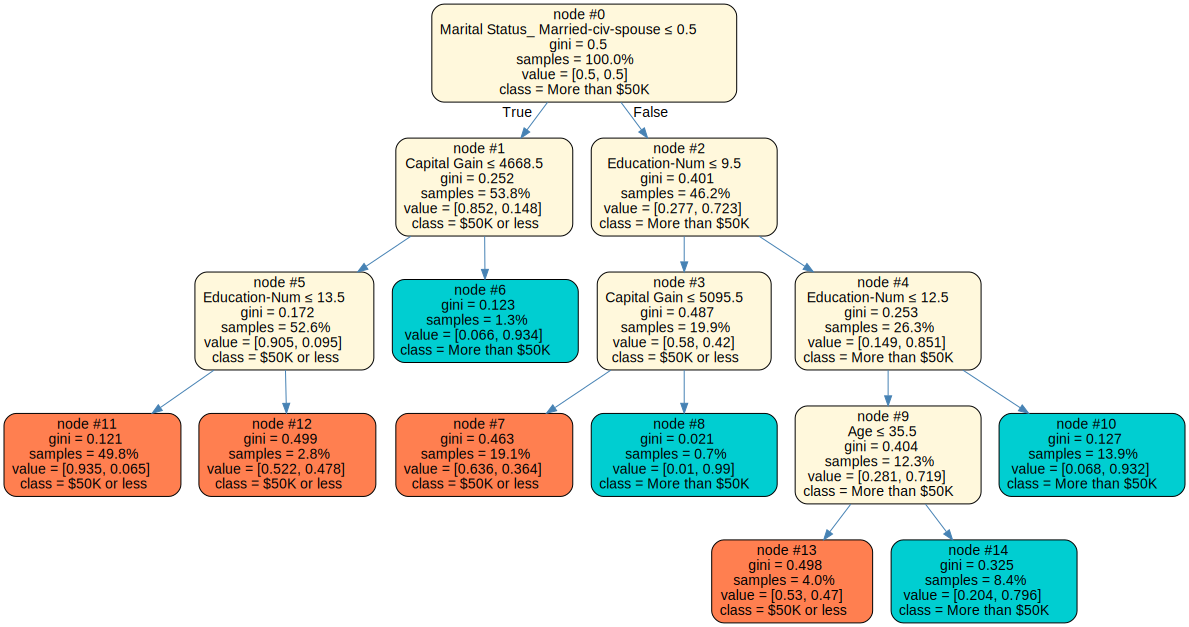

In [106]:
from skater.util.dataops import show_in_notebook
from graphviz import Source
from IPython.display import SVG

graph = Source(surrogate_explainer.plot_global_decisions(colors=['coral', 'darkturquoise'], 
                                          file_name='test_tree_pre.png').to_string())
svg_data = graph.pipe(format='svg')
with open('dtree_structure.svg','wb') as f:
    f.write(svg_data)
SVG(svg_data)

In [107]:
surrogate_explainer.decisions_as_txt()

if Marital Status_ Married-civ-spouse <= 0.5 {
  if Capital Gain <= 4668.5 {
    if Education-Num <= 13.5 {
        Predicted Label: 0
    } else {
        Predicted Label: 0
    }
  } else {
      Predicted Label: 1
  }
} else {
  if Education-Num <= 9.5 {
    if Capital Gain <= 5095.5 {
        Predicted Label: 0
    } else {
        Predicted Label: 1
    }
  } else {
    if Education-Num <= 12.5 {
      if Age <= 35.5 {
          Predicted Label: 0
      } else {
          Predicted Label: 1
      }
    } else {
        Predicted Label: 1
    }
  }
}


### Interesting rules from the surrogate tree

Here are some interesting rules you can observe from the above tree
- If `Marital Status_ Married-civ-spouse` < 0.5 (means 0) and `Capital Gain` <= 4668.5 and `Education-num` <= 13.5  __→__ 93.5% chance of person making <= \$50K 
- If `Marital Status_ Married-civ-spouse` < 0.5 (means 0) and `Capital Gain` >= 4668.5 __→__ 93.4% chance of person making > \$50K 

Feel free to derive more interesting rules from this and also your own models! Let's look at how our surrogate model performs on the test dataset now

In [108]:
surrogate_predictions = surrogate_explainer.predict(X_test)
class_labels = list(set(labels))
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=surrogate_predictions, classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8402
Precision: 0.8391
Recall: 0.8402
F1 Score: 0.8396

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      7455
           1       0.67      0.65      0.66      2314

    accuracy                           0.84      9769
   macro avg       0.78      0.78      0.78      9769
weighted avg       0.84      0.84      0.84      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       6699   756
        1        805  1509


# Model Interpretation with SHAP

**SHAP (SHapley Additive exPlanations)** is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on what they claim! (do check out the [SHAP NIPS paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) for details).



### Install

SHAP can be installed from [PyPI](https://pypi.org/project/shap)

```
pip install shap
```

or [conda-forge](https://anaconda.org/conda-forge/shap)

```
conda install -c conda-forge shap 
```

The really awesome aspect about this framework is while SHAP values can explain the output of any machine learning model, for really complex ensemble models it can be slow. But they have developed a high-speed exact algorithm for tree ensemble methods ([Tree SHAP arXiv paper](https://arxiv.org/abs/1802.03888)). Fast C++ implementations are supported for *XGBoost*, *LightGBM*, *CatBoost*, and *scikit-learn* tree models!

SHAP (SHapley Additive exPlanations) assigns each feature an importance value for a particular prediction. Its novel components include: the identification of a new class of additive feature importance measures, and theoretical results showing there is a unique solution in this class with a set of desirable properties. Typically, SHAP values try to explain the output of a model (function) as a sum of the effects of each feature being introduced into a conditional expectation. Importantly, for non-linear functions the order in which features are introduced matters. The SHAP values result from averaging over all possible orderings. Proofs from game theory show this is the only possible consistent approach. 

An intuitive way to understand the Shapley value is the following: The feature values enter a room in random order. All feature values in the room participate in the game (= contribute to the prediction). The Shapley value __$ϕ_{ij}$__ is the average marginal contribution of feature value __$x_{ij}$__ by joining whatever features already entered the room before, i.e.

$$\phi_{ij}=\sum_{\text{All.orderings}}val(\{\text{features.before.j}\}\cup{}x_{ij})-val(\{\text{features.before.j}\})$$

The following figure from the KDD 18 paper, [_Consistent Individualized Feature Attribution for Tree Ensembles_](https://arxiv.org/pdf/1802.03888.pdf) summarizes this in a nice way!

![](https://i.imgur.com/6Rc1dsa.png)

Let's now dive into SHAP and leverage it for interpreting our model!

## Explain predictions with SHAP

Here we use the Tree SHAP implementation integrated into XGBoost to explain the test dataset! Remember that there are a variety of explainer methods based on the type of models you are building. We estimate the SHAP values for a set of samples (test data)

In [299]:
explainer = shap.TreeExplainer(xgc, data=X_train)
shap_values = explainer.shap_values(X_test)
pd.DataFrame(shap_values).head()

0         1         2         3         4         5         6   \
0 -0.471925  0.118591 -0.274616 -0.025379 -0.356285 -0.000710 -0.031417   
1  0.955741 -0.385899 -0.363928 -0.078169  0.099341 -0.000711 -0.030374   
2 -0.685702  1.476501 -0.401882 -0.152597  0.670028 -0.002417 -0.003786   
3  0.503695  1.144242 -0.329139 -0.054358  0.116713  0.003293 -0.006756   
4  0.073325 -0.342993 -4.441609 -0.021464  1.394542  0.002957 -0.009239   

         7    8         9   ...        81        82   83        84        85  \
0  0.024964  0.0  0.000822  ...  0.000028  0.000686  0.0  0.002613 -0.000495   
1 -0.022767  0.0 -0.027612  ...  0.000028  0.003824  0.0  0.000404 -0.000177   
2  0.018600  0.0 -0.014189  ...  0.000027  0.005144  0.0  0.001762 -0.000491   
3  0.025381  0.0  0.109640  ...  0.000027  0.001159  0.0  0.002137 -0.000578   
4  0.030924  0.0  0.010339  ...  0.000027  0.000742  0.0  0.001804 -0.000547   

    86        87        88        89        90  
0  0.0  0.000190  0.035662  0.002651 -0.000139  
1  0.0  0.000249  0.045159  0.003527 -0.000117  
2  0.0  0.000193  0.022214  0.003158 -0.000102  
3  0.0  0.000249  0.053730  0.002967 -0.000115  
4  0.0  0.000174  0.030628  0.002670 -0.000126  

[5 rows x 91 columns]

This returns a matrix of SHAP values (`# samples x # features`). Each row sums to the difference between the model output for that sample and the expected value of the model output (which is stored as `expected_value` attribute of the explainer). Typically this difference helps us in explaining why the model is inclined on predicting a specific class outcome.

In [300]:
print('Expected Value:', explainer.expected_value)

Expected Value: -3.027303493187901


### Predicting when a person's income <= \$50K 

SHAP gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting the person's income as below \$50K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [301]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

### Predicting when a person's income > \$50K 

Similarly, SHAP gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting the person's income as greater than \$50K.

In [302]:
shap.force_plot(explainer.expected_value, shap_values[5,:], X_test.iloc[5,:])

## Visualizing and explaining multiple predictions

One of the key advantages of SHAP is it can build beautiful interactive plots which can visualize and explain multiple predictions at once. Here we visualize model prediction decisions for the first 1000 test data samples.

In [305]:
shap.force_plot(explainer.expected_value, shap_values[:500,:], X_test.iloc[:500,:])

The above visualization can be interacted with in multiple ways. The default visualization shows some interesting model prediction pattern decisions.

- People who are married seem to have higher SHAP values leading towards the model making decisions of them making > \$50K
- People who are not-married or divorced seem to have higher SHAP values leading towards the model making decisions of them making < \$50K
- Factors like Education Level, Age and Capital Gain also seem to play crucial roles in model decisions

Definitely interesting how we can find out patterns which lead to the model making specific decisions and being able to provide explanations for them.

## Feature Importances with SHAP

This basically takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

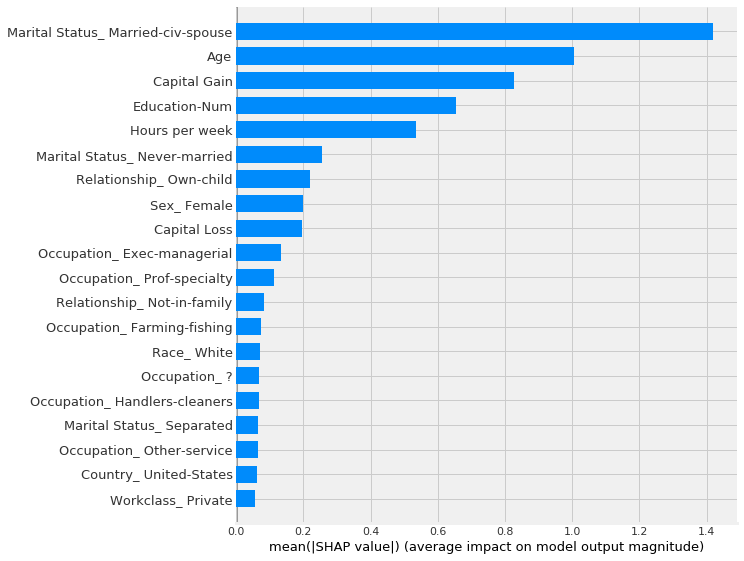

In [306]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

## SHAP Summary Plot

Besides a typical feature importance bar chart, SHAP also enables us to use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the age and marital status feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age or marital status. In other words, capital gain effects a few predictions by a large amount, while age or marital status effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

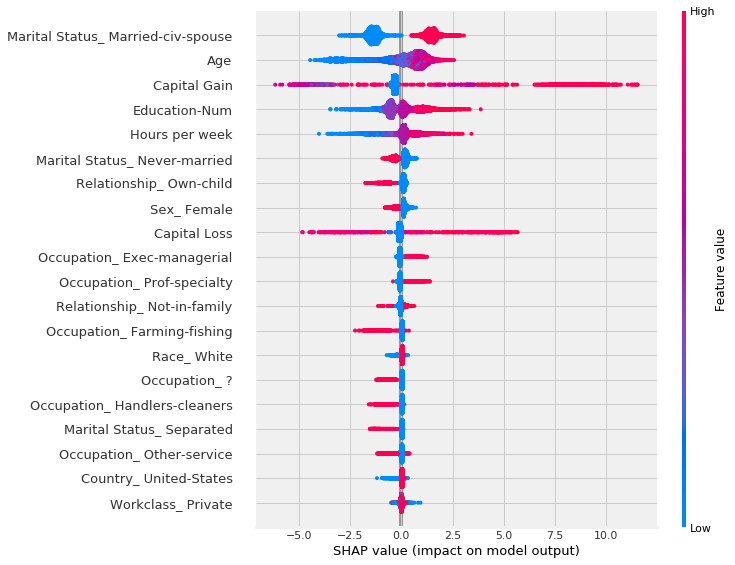

In [307]:
shap.summary_plot(shap_values, X_test)

## SHAP Dependence Plots

SHAP dependence plots show the effect of a single (or two) feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature can be chosen for coloring to highlight possible interactions.

You will also notice it's similarity with Skater's Partial Dependence Plots!

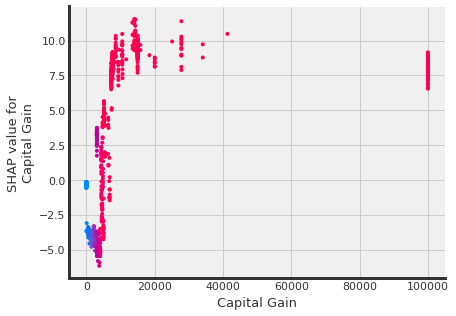

In [308]:
shap.dependence_plot(ind='Capital Gain', interaction_index='Capital Gain',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

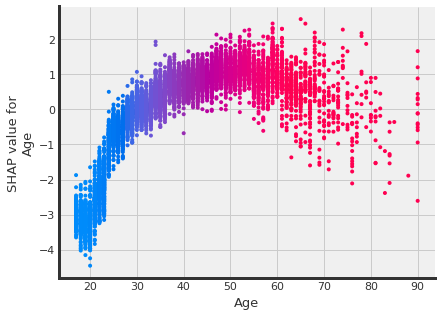

In [309]:
shap.dependence_plot(ind='Age', interaction_index='Age',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

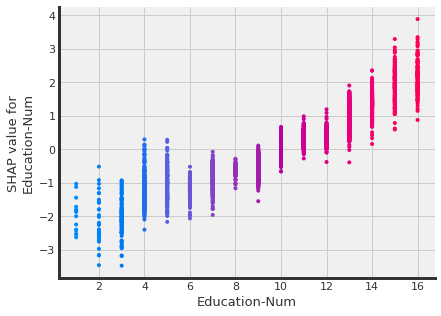

In [310]:
shap.dependence_plot(ind='Education-Num', interaction_index='Education-Num',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

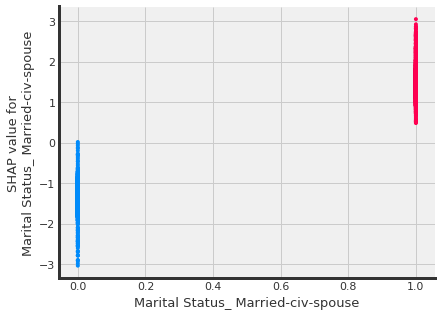

In [311]:
shap.dependence_plot(ind='Marital Status_ Married-civ-spouse', 
                     interaction_index='Marital Status_ Married-civ-spouse',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

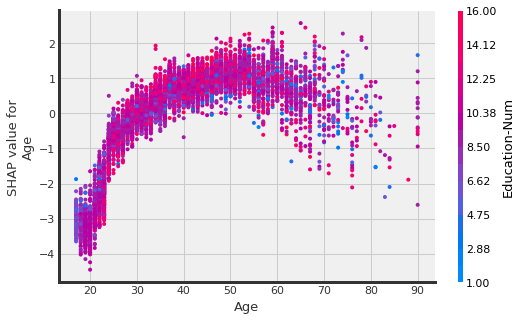

In [312]:
shap.dependence_plot(ind='Age', interaction_index='Education-Num', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)

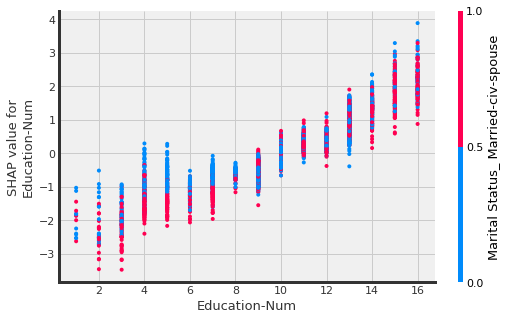

In [313]:
shap.dependence_plot(ind='Education-Num', interaction_index='Marital Status_ Married-civ-spouse', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)

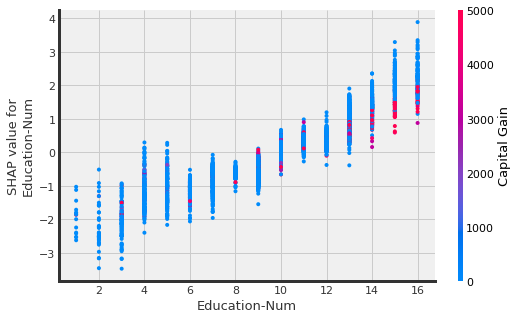

In [314]:
shap.dependence_plot(ind='Education-Num', interaction_index='Capital Gain', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)